# Task 2: The Bookshop

In [1]:
# Muting warnings
import warnings
warnings.filterwarnings('ignore')

# For analysis and visulaisation
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import wordcloud

# For processing texts and Models
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import re
from sklearn.feature_extraction.text import CountVectorizer
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [2]:
bbc_df = pd.read_csv('bbc_news.csv')

In [3]:
bbc_df.head()

,data,labels
0,Musicians to tackle US red tape Musicians gro...,entertainment
1,"U2s desire to be number one U2, who have won ...",entertainment
2,Rocker Doherty in on-stage fight Rock singer ...,entertainment
3,Snicket tops US box office chart The film ada...,entertainment
4,"Oceans Twelve raids box office Oceans Twelve,...",entertainment


### Observation

The dataset consists of two columns: data, which contains the text of the news stories, and labels

In [4]:
bbc_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2236 entries, 0 to 2235
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   data    2233 non-null   object
 1   labels  2236 non-null   object
dtypes: object(2)
memory usage: 35.1+ KB


In [5]:
#Check for missing values

bbc_df.isnull().sum()

data      3
labels    0
dtype: int64

In [6]:
#Drop missing values

bbc_df.dropna(inplace=True)

In [7]:
bbc_df.size

4466

In [8]:
#check duplicates

bbc_df.duplicated().sum()

106

In [9]:
#Drop duplicates

bbc_df.drop_duplicates(inplace=True)

In [10]:
# Function for counting label values 
def count_values_in_column(df,feature):
    total=bbc_df.loc[:,feature].value_counts(dropna=False)
    percentage=round(bbc_df.loc[:,feature].value_counts(dropna=False,normalize=True)*100,2)
    return pd.concat([total,percentage],axis=1,keys=['Total','Percentage'])

In [11]:
count_values_in_column(bbc_df,'labels')

,Total,Percentage
labels,,
sport,505,23.74
business,504,23.70
politics,403,18.95
entertainment,369,17.35
tech,346,16.27


<Axes: xlabel='labels'>

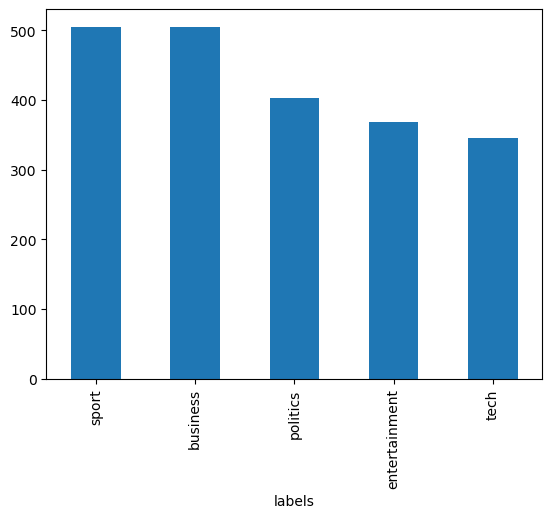

In [12]:
#plot the count of the label

bbc_df['labels'].value_counts().plot(kind='bar')

##### Observation

The distribution is close to evenly distributed

# Word Frequency Analysis

<Axes: xlabel='word'>

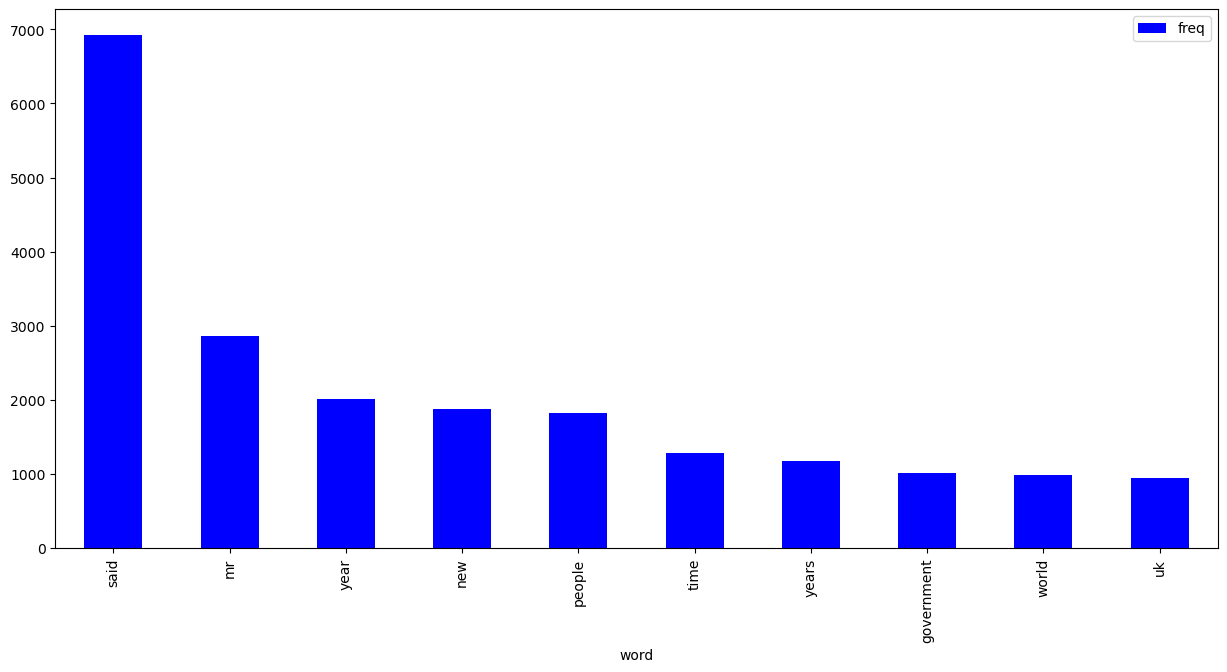

In [13]:
#plot a word frequencey of top 10 words in the data

cv = CountVectorizer(stop_words = 'english')

words = cv.fit_transform(bbc_df['data'])

sum_words = words.sum(axis = 0)

words_freq = [(word, sum_words[0, idx]) for word, idx in cv.vocabulary_.items()]

words_freq = sorted(words_freq, key = lambda x: x[1], reverse = True)

frequency = pd.DataFrame(words_freq, columns = ['word', 'freq'])

frequency.head(10).plot(x = 'word', y = 'freq', kind = 'bar', figsize = (15,7), color = 'blue')

##### Observation

"Said" is the most common word in the data given, followed by "mr" and "year"

# Cleaning Data

## Preprocessing

In [14]:
#show the special characters in the text column

bbc_df[bbc_df['data'].str.contains(r'[^A-Za-z0-9 ]',regex=True)]

# Function to remove special characters
def remove_special_characters(text):
    text = re.sub(r'[^A-Za-z0-9 ]', '', text)
    return text

# Apply function to remove special characters
bbc_df['data'] = bbc_df['data'].apply(remove_special_characters)

In [15]:
def special_characters(data):
    special = data.str.contains(r'[^A-Za-z0-9 ]',regex=True).sum()
    return special

# Applying special_characters function
special_characters(bbc_df['data'])

0

## Downloading WordNet and Stopwords

In [16]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/kehindeoabe/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [17]:
nltk.download ('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/kehindeoabe/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

#### Observation

Stopwords

Stopwords are common words (like "the," "is," "in," etc.) that are often filtered out in Natural Language Processing (NLP) tasks because they do not contribute significant meaning to the text analysis

Here are a few reasons why we need stopwords:

- Noise Reduction

- Efficiency

- Improved Accuracy


WordNet

WordNet is a lexical database that groups English words into sets of synonyms called synsets and provides short definitions and usage examples

## Removing other Noises

In [18]:
def remove_URL(text):
    return re.sub(r"https?://\S+|www\.\S+", "", text)

def remove_html(text):
    html = re.compile(r"<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});")
    return re.sub(html, "", text)

def remove_non_ascii(text):
    return re.sub(r'[^\x00-\x7f]',r'', text)

def remove_punct(text):
    return re.sub(r'[]!"$%&\'()*+,./:;=#@?[\\^_`{|}~-]+', "", text)

In [19]:
# Applying the cleaining functions defined above
bbc_df["data"] = bbc_df["data"].apply(lambda x: remove_URL(x))
bbc_df["data"] = bbc_df["data"].apply(lambda x: remove_html(x))
bbc_df["data"] = bbc_df["data"].apply(lambda x: remove_non_ascii(x))
bbc_df["data"] = bbc_df["data"].apply(lambda x: remove_punct(x))

## Remove Stopwords

In [20]:
# Removing stopwords
stop = stopwords.words('english')

bbc_df['removed_stopwords'] = bbc_df['data'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

## Lemmatization

In [21]:
# Defining and applying the lemmatization function to lemmatize texts
def lemmatized_text(corpus):
    lemmatizer = WordNetLemmatizer()
    return [' '.join([lemmatizer.lemmatize(word) for word in review.split()]) for review in corpus]

bbc_df['lemmatized_texts'] = lemmatized_text(bbc_df['removed_stopwords'])

In [22]:
bbc_df.head()

,data,labels,removed_stopwords,lemmatized_texts
0,Musicians to tackle US red tape Musicians gro...,entertainment,Musicians tackle US red tape Musicians groups ...,Musicians tackle US red tape Musicians group t...
1,U2s desire to be number one U2 who have won t...,entertainment,U2s desire number one U2 three prestigious Gra...,U2s desire number one U2 three prestigious Gra...
2,Rocker Doherty in onstage fight Rock singer P...,entertainment,Rocker Doherty onstage fight Rock singer Pete ...,Rocker Doherty onstage fight Rock singer Pete ...
3,Snicket tops US box office chart The film ada...,entertainment,Snicket tops US box office chart The film adap...,Snicket top US box office chart The film adapt...
4,Oceans Twelve raids box office Oceans Twelve ...,entertainment,Oceans Twelve raids box office Oceans Twelve c...,Oceans Twelve raid box office Oceans Twelve cr...


## Top 20 words from the Lemmatized words

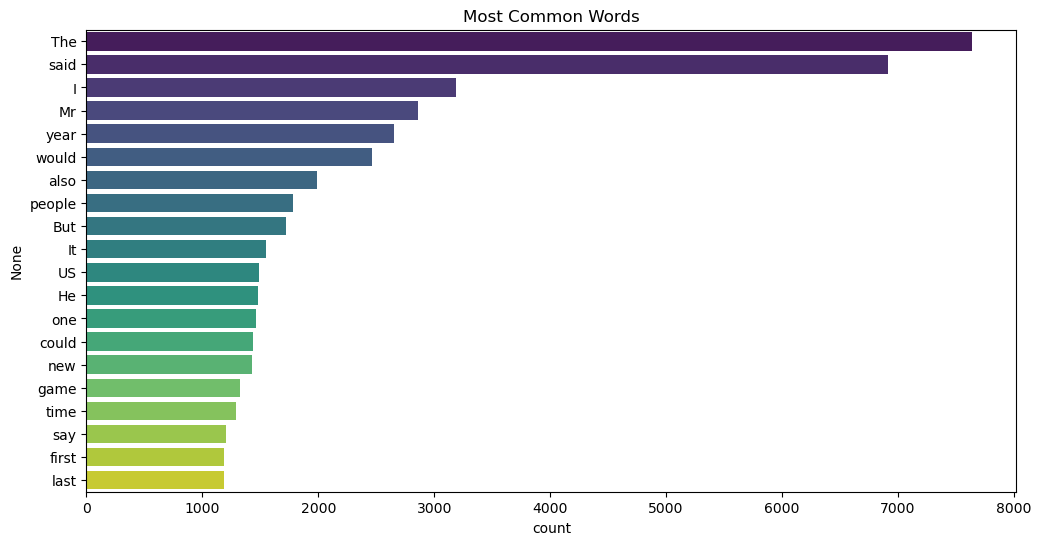

In [23]:
## Visualizing the most common words in the dataset

# Function to plot the most common words
def plot_most_common_words(corpus, n_words):
    words = ' '.join(corpus)
    words = words.split()
    top_n = pd.Series(words).value_counts().head(n_words)
    plt.figure(figsize=(12,6))
    sns.barplot(x=top_n, y=top_n.index, palette='viridis')
    plt.title('Most Common Words')
    plt.show()

# Plotting the most common words in the dataset

plot_most_common_words(bbc_df['lemmatized_texts'], 20)

## Visualizing text content through WordCloud

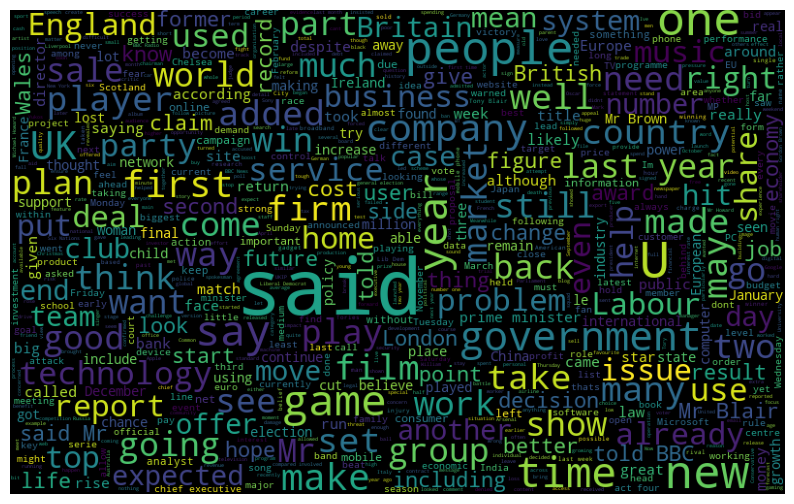

In [24]:
# Wordcloud visualises words in the texts base on frequencey 
wc = wordcloud.WordCloud(stopwords=wordcloud.STOPWORDS,max_font_size=80, max_words=5000, width = 800, height = 500,background_color='black').generate(' '.join(txt for txt in bbc_df["lemmatized_texts"]))
fig, ax = plt.subplots(figsize=(10,7))
ax.imshow(wc, interpolation='bilinear')
ax.set_axis_off()
plt.imshow(wc)

# Model Implementation

# Method 1

## Categorization and Relevance Scoring:

This is done to develop models to categorize the stories and score their relevance. This is based on the following system:

- Keyword Matching: Identify key terms that are highly relevant to the bookshop's interests.

- Sentiment Analysis: Determine the sentiment of the stories to prioritize positive, neutral, or negative news based on the client's preference.

- Topic Modeling: Use topic modeling to uncover hidden themes in the stories.


## Keyword-Based Categorization and Scoring


- Define Relevant Keywords: Identify keywords that are important to the bookshop (e.g., books, authors, publishing, literature).

- Calculate Relevance Scores: Assign scores to stories based on the presence of these keywords.

In [25]:
# Define relevant keywords
relevant_keywords = {
    'books': 10,
    'authors': 8,
    'publishing': 7,
    'literature': 6,
    'novel': 5,
    'biography': 5,
    'bestseller': 8,
    'review': 4,
    'read': 3,
    'bookshop': 10
}

# Function to calculate relevance score based on keyword matching
def calculate_relevance_score(text):
    score = 0
    for keyword, weight in relevant_keywords.items():
        if keyword in text:
            score += weight
    return score

# Calculate relevance scores for each story
bbc_df['relevance_score'] = bbc_df['lemmatized_texts'].apply(calculate_relevance_score)

# Display the first few rows with relevance scores
bbc_df.head()


,data,labels,removed_stopwords,lemmatized_texts,relevance_score
0,Musicians to tackle US red tape Musicians gro...,entertainment,Musicians tackle US red tape Musicians groups ...,Musicians tackle US red tape Musicians group t...,0
1,U2s desire to be number one U2 who have won t...,entertainment,U2s desire number one U2 three prestigious Gra...,U2s desire number one U2 three prestigious Gra...,0
2,Rocker Doherty in onstage fight Rock singer P...,entertainment,Rocker Doherty onstage fight Rock singer Pete ...,Rocker Doherty onstage fight Rock singer Pete ...,0
3,Snicket tops US box office chart The film ada...,entertainment,Snicket tops US box office chart The film adap...,Snicket top US box office chart The film adapt...,5
4,Oceans Twelve raids box office Oceans Twelve ...,entertainment,Oceans Twelve raids box office Oceans Twelve c...,Oceans Twelve raid box office Oceans Twelve cr...,4


The numbers associated with each keyword in the relevant_keywords dictionary represent the weight or importance of that keyword in determining 

the relevance score of a news story. These weights are used to prioritize certain keywords over others based on their relevance to the 

bookshop's business. Here's an explanation for each keyword's weight:

#### For Example

books: Weight = 10

Central to the bookshop's business, so given the highest weight.

In [26]:
# The sentence with the highest relevance score in the data, and its corresponding relevance score

max_relevance_score = bbc_df['relevance_score'].max()
most_relevant_story = bbc_df[bbc_df['relevance_score'] == max_relevance_score]['lemmatized_texts'].values[0]
print("Most relevant story:", most_relevant_story)


Most relevant story: New Harry Potter top book chart Harry Potter HalfBlood Prince topped Amazons book chart le 24 hour release date 16 July announced Thousands customer placed preorders amazoncouk website sixth book series Rowling revealed completed novel Tuesday ahead scheduled announcement 25 December It published simultaneously UK US Canada Australia New Zealand South Africa JK Rowlings fifth book wizard series Harry Potter Order Phoenix Amazons largest preordered item ever 420000 copy preordered prior release June 2003 Customers preorder Harry Potter HalfBlood Prince avoid standing long queue bookshop day book release next July The fact book already hit number one Hot 100 book chart show incredibly excited customer sixth Harry Potter said Amazons Robin Terrell Harry Potter HalfBlood Prince take story Harry Potters sixth year Hogwarts School Witchcraft Wizardry Lord Voldemort grows stronger Rowling already revealed HalfBlood Prince neither Harry Voldemort And added opening chapter 

## Building the Recommendation System

- Sort Stories by Relevance: Present the most relevant stories to the client.

- Create a Dashboard: Develop a dashboard to visualize the most relevant stories and their scores.

- Automate the Process: Set up a system to regularly update the stories and scores.

In [27]:
# Sort stories by relevance score in descending order
sorted_stories_df = bbc_df.sort_values(by='relevance_score', ascending=False)

# Display the top 10 most relevant stories
top_stories_df = sorted_stories_df.head(10)
top_stories_df[['lemmatized_texts', 'labels', 'relevance_score']]


,lemmatized_texts,labels,relevance_score
247,New Harry Potter top book chart Harry Potter H...,entertainment,28
203,Da Vinci Code lousy history The plot internati...,entertainment,23
168,Levy take Whitbread novel prize Orange Prize w...,entertainment,20
169,Levy tipped Whitbread prize Novelist Andrea Le...,entertainment,20
127,Mutant book win Guardian prize A book evolutio...,entertainment,18
119,France set new Da Vinci novel French bookselle...,entertainment,15
18,Director Nairs Vanity project Indian film dire...,entertainment,14
229,Paraguay novel win US book prize A novel set 1...,entertainment,14
1755,Hagues sixfigure earnings shown The reward lea...,politics,14
54,Fantasy book win Hollywood deal A British auth...,entertainment,13


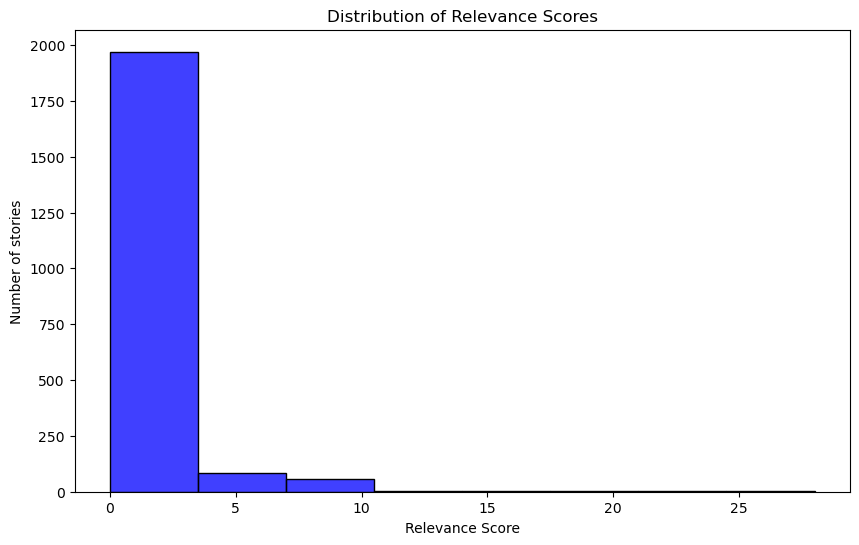

In [28]:
# Plot of the distribution of relevance scores in scatter plot

plt.figure(figsize=(10, 6))
sns.histplot(bbc_df['relevance_score'], bins=8, color='blue')
plt.title('Distribution of Relevance Scores')
plt.xlabel('Relevance Score')
plt.ylabel('Number of stories')
plt.show()



## Automation and Integration

To automate this process and integrate it with the bookshop's systems, the following steps can be implemented:

- Data Pipeline: Set up a data pipeline to regularly fetch and process new BBC news stories.

- Scoring System: Automate the relevance scoring using the defined keyword-based approach or a more advanced model.

- Integration: Connect the system to the bookshop's inventory and marketing platforms to align recommendations with inventory and promotional strategies.

## Benefits to the Client

1) Improved Sales:

- Stocking books related to trending news topics can attract more customers and boost sales.

- Targeted promotions based on relevant news stories can drive traffic and sales.

2) Customer Satisfaction:

- Curating book selections based on customer interests reflected in news trends can enhance customer satisfaction and loyalty.

3) Inventory Management:

- Predicting demand for certain genres or topics based on news trends can optimize stock levels and reduce risks of overstocking or understocking.

4) Marketing Strategies:

- Leveraging current news stories for marketing campaigns can increase engagement and relevance.


# Method 2

## Using Machine Learning: Content-Based Filtering Methods Using TF-IDF and Cosine Similarity

- Uses the features of items (e.g., keywords from the news stories) to recommend similar items.

- Can be implemented using techniques like TF-IDF or word embeddings to represent text and calculate similarities.


- Process

Convert Text Data to TF-IDF Features
Using TF-IDF vectorizer to transform the lemmatized text data into numerical features.

Calculate Cosine Similarity
Calculate the cosine similarity between news stories to find similar items.

Recommend Top N Similar Stories
For each news story, recommend the top N most similar stories.



In [29]:
# Step 1: Convert text data to TF-IDF features
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(bbc_df['lemmatized_texts'])

# Step 2: Calculate cosine similarity between news stories
cosine_sim_matrix = cosine_similarity(tfidf_matrix, tfidf_matrix)

# Function to get top N similar stories
def get_top_n_similar_stories(index, n=5):
    similarity_scores = list(enumerate(cosine_sim_matrix[index]))
    similarity_scores = sorted(similarity_scores, key=lambda x: x[1], reverse=True)
    top_n_similar = similarity_scores[1:n+1]  # Skip the first one since it is the story itself
    return top_n_similar

# Get top 10 similar stories for the first news story in the dataset
top_similar_stories = get_top_n_similar_stories(0, 10)
top_similar_stories_indices = [i[0] for i in top_similar_stories]

# Display the top 10 similar stories
top_similar_stories_df = bbc_df.iloc[top_similar_stories_indices]
top_similar_stories_df[['lemmatized_texts', 'labels', 'relevance_score']]


,lemmatized_texts,labels,relevance_score
1482,Visa decision every 11 minute Visa processing ...,politics,0
2082,Musicians upbeat net Musicians embracing inter...,tech,0
99,India deport Bollywood actress India ordered d...,entertainment,0
1528,Lib Dems demand new inquiry A judge look David...,politics,4
512,SEC rethink postEnron rule The US stock market...,business,3
801,US EU tariff chaos trade row The US asked Worl...,business,4
734,Battered dollar hit another low The dollar fal...,business,0
1448,Blunkett row end Blair Prime Minister Tony Bla...,politics,7
1609,Visa row mandarin made Sir John The top civil ...,politics,4
379,Franz man seek government help Franz Ferdinand...,entertainment,3


# Benefits of This Approach

- Personalization: Recommends news stories similar to ones the user is interested in, enhancing user engagement.

- Scalability: Can handle a large number of stories efficiently using vectorized operations.

- Relevance: By updating the TF-IDF matrix regularly, the system remains current with new stories and trends. This can be automated


# Conclusion

Other Algorithm that could be considered in buidling this model is Long-Short Term memory, which is a type of Recurrent Neural Network (RNN)